<img src="strategiepilot_sign.png">

# Willkommen in Ihrem persönlichen Jupyter-Notebook.

Sie können in diesem Notebook alle Beispiele live nachvollziehen, aber auch eigene Varianten ausprobieren.  
In der Menüleiste finden sich die wichtigsten Funktionen für "Maus"-User.  
Hier noch einige sehr hilfreiche Tastatur-Kürzel für effizientes Arbeiten mit der Tastatur:  

+ **Ausführen einer Zelle mit ... [SHIFT+ENTER]**  <
+ Eine neue leere Zelle über einer Zelle einfügen mit ... [a]
+ Eine neue leere Zelle unter einer Zelle einfügen mit ... [b]
+ Eine Zelle löschen/entfernen !!VORSICHT!! mit ... [dd]
+ Eine Zelle in Markdown-Format umwandeln mit ... [m]
+ Eine Zelle n Coding-Format umwandeln mit ... [y]

# Sentimentanalyse - Usecase Facebookposts TELEKOM

    1. Settings
    2. Datensätze (Trainingsdaten laden)
    3. Modell trainieren
    4. Modell auf neuen Datensätzen anwenden

## (1) Settings

Zunächst benötigen wir eine Reihe von Werkzeugen, die wir uns in unser Skript reinladen.
Zusätzlich definieren wir ein paar Grundeinstellungen, z.B. wo unsere Daten zu finden sind, wo wir die Ergebnisse abspeichern, usw..

In [2]:
import os
import pandas as pd
import numpy as np

import spacy
from spacy.lang.de import German
from spacy import displacy
from spacy.lang.de.stop_words import STOP_WORDS
nlp = spacy.load('de_core_news_md')

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve

#from IPython.core.interactiveshell import interactiveshell
#InteractiveShell.ast_node_interactivity="all"

pd.set_option('display.max_colwidth', None)

In [3]:
WORKDIR = '/Users/andreas/Projects/Magenta'
DATAFILE = 'TelekomFacebookComments vercodet.xlsx'

## (2) Trainingsdaten laden und aufbereiten

Dann laden wir unsere Rohdaten in unser Programm.  
Folgende Bearbeitungsschritte nehmen wir auf den Rohdaten vor:  
- Benennung der Datenspalten in "Comment" und "Target"
- Zuweisung entsprechender Datentypen (Text = String und Target = integer)
- Filtern der Datensätze auf Datensätze, die eine 1,2,3,4 oder 5 Etikettierung haben
- Zuweisung von "Etiketten" zu den Targetwerten 1,2,3,4,5
- Infos über unsere Datentabelle ausgeben: # Datensätze, Exemplarische Beispiele, Verteilung

(1018, 3)


<AxesSubplot:title={'center':'Verteilung der Sentiments - Facebook Posts'}>

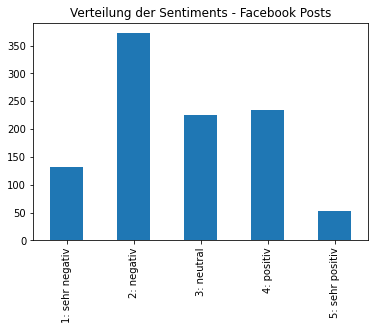

In [4]:
posts = pd.read_excel(os.path.join(WORKDIR, DATAFILE), header=1, usecols=[1,2], )
posts.columns =  ["Comment", "Target"]
posts.Comment = posts.Comment.astype("string")
posts = posts.loc[posts.Target.isin([1,2,3,4,5])]
posts = posts.dropna()
posts.Target = posts.Target.astype("int")
labelKeys = {1: "1: sehr negativ", 2: "2: negativ", 3: "3: neutral", 4: "4: positiv", 5: "5: sehr positiv"}
#labelKeys = {1: "negativ", 2: "negativ", 3: "neutral", 4: "positiv", 5:"positiv"}

posts["Label"] = posts.Target.replace(to_replace=labelKeys).astype("category")
print(posts.shape)
posts.head(3)

# orderLabels = ["sehr negativ", "negativ", "neutral", "positiv", "sehr positiv"]
posts.Label.value_counts().sort_index().plot(kind="bar", title="Verteilung der Sentiments - Facebook Posts")

## (3) Classfier trainieren

### (3.1) Vorbereitung
Unsere Daten sind jetzt geladen.
Bevor wir unser Modell trainieren machen wir noch folgende Vorbereitungen:  

X, y aufbauen:
- Aufbau einer Trainingsmatrix X (unsere Posts)
- Aufbau eines Targetvektor y (unsere Labels auf die wir hintrainieren)
- Splitten unseres Datensets 80% für Training und 20% für Testen (Evaluation)

Texte (X) in numerisches Format umwandeln (TFIDF-Vectorization)


In [5]:
# Trainingsdaten: X-matrix und y-Vector definieren
X,y = posts.Comment, posts.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# Texte in numerische Form umwandeln
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


Aus allen X_test Posts wurde ein internes Vokabular aufgebaut:  
Wir lassen uns zur Veranschaulichung die Länge des Vokabulars zeigen und  
exemplarisch schauen wir uns die ersten 20 Wörter an.

In [6]:
print(f"Länge des Vokabulars: {len(tfidf.vocabulary_)} Wörter")
print(list(enumerate([*tfidf.vocabulary_][:20])))

Länge des Vokabulars: 4905 Wörter
[(0, 'ist'), (1, 'aber'), (2, 'wohl'), (3, 'mal'), (4, 'wieder'), (5, 'nur'), (6, 'in'), (7, 'der'), (8, 'magenta'), (9, 'bubble'), (10, 'bonn'), (11, 'fall'), (12, 'was'), (13, 'aplikasyon'), (14, 'uygu'), (15, 'lama'), (16, 'hallo'), (17, 'ich'), (18, 'bin'), (19, 'festnetznutzer')]


Für jeden Post wird eine entsprechende Datenzeile mit Gewichten erzeugt.  
Jedes Wort im Post wird durch eine Zahl (ihr relatives Gewicht) repräsentiert.   

In [7]:
print(X_train[0].split()[:15])
print(X_train_vec[0][:15])

['Bei', 'mir', 'neben', 'dem', 'Haus', 'ragt', 'das', 'frisch', 'verlegte', 'Glasfaserkabel', 'schon', 'aus', 'der', 'Erde', 'raus.']
  (0, 4521)	0.20832956859504462
  (0, 1432)	0.3556493163909074
  (0, 822)	0.3556493163909074
  (0, 857)	0.43303732789857313
  (0, 2740)	0.277013305552409
  (0, 1018)	0.28201661430649533
  (0, 2202)	0.31361382625240103
  (0, 3114)	0.18548886545775684
  (0, 4628)	0.2239704579217225
  (0, 2755)	0.18220806623561642
  (0, 4671)	0.2907977453476769
  (0, 190)	0.18955058223214769
  (0, 2292)	0.15238044568300607


### (3.2) Algorithmus auswählen und Modell trainieren
Für unser Training stehen uns heute zwei für Text-Classification gut geeignete Algorithmen zur Verfügung.
(a) Die lineare Support Vector Machine
(b) Eine logistische Regression (Classifier)

In [8]:

# Algorithmus auswählen
clf = LinearSVC(dual=False, C=1.5)     # Algorithmus = Linear Support Vector Machine
# clf = LogisticRegression()           # Algorithmus = Logistic Regression Classifier

# Classifier trainieren
clf = clf.fit(X_train_vec, y_train)
print("Modell ist jetzt trainiert und kann getestet werden")


Modell ist jetzt trainiert und kann getestet werden


Jetzt schauen wir mal wie "gut" unser Modell funktioniert.  
Dafür haben wir uns ja ein Testset mit 20% unserer Daten aufbehalten.  
Diese Daten hat unser trainiertes Model noch nie gesehen.  
Die "Accuracy" die unser Modell auf diesen Testdaten erzielt, ist ein Indikator, wie viele Fehler unser Modell in der realen Anwendungspraxis tatsächlich machen würde.

Wir lassen uns den sog. "Classification Report" anzeigen:


In [9]:
# Classifier auf den Testdaten anwenden
prediction = clf.predict(X_test_vec)
y_true = y_test

report = classification_report(y_true, prediction)
print(report)

                 precision    recall  f1-score   support

1: sehr negativ       0.45      0.35      0.39        26
     2: negativ       0.68      0.73      0.71        75
     3: neutral       0.75      0.53      0.62        45
     4: positiv       0.64      0.87      0.74        47
5: sehr positiv       0.71      0.45      0.56        11

       accuracy                           0.66       204
      macro avg       0.65      0.59      0.60       204
   weighted avg       0.66      0.66      0.65       204



Bei der Analyse (Wo macht das Modell welche Fehler?) hilft die sog. "Confusion Matrix"

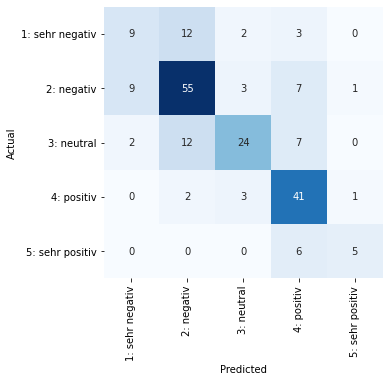

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
mat = confusion_matrix(y_true, prediction,)
category_names = sorted(y.unique())
sns.heatmap(mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=category_names, yticklabels=category_names)
plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.show()

## (4) Trainiertes Modell auf neuen Datensätzen anwenden
Das trainierte Modell kann man natürlich auch ad hoc selbst testen, indem man sich ein paar neue Testposts ausdenkt und sie vom Modell klassifizieren lässt.

In [11]:
testPosts = [
    "Sehr geil! dass Ihr die EM 2021 so toll unterstützt",
    "Ich warte schon seit drei Wochen auf Euren Techniker",
    "Gut, dass man nichts besseres zu tun hat bei der Telekom",
    "Ich bin super zufrieden. Bin schon seit 10 Jahren Stammkunde und hatte nie Probleme",
    "Der neue Kabelrouter funzt ganz schön schnell um die Ecke",
    "Wünsche mir noch mehr Kanäle auf Magenta TV",
    "Aber sicher doch!", 
    "Suuuper!"
    ]

In [12]:
# Classifier auf neuen Date anwenden
result = clf.predict(tfidf.transform(pd.Series(testPosts)))
# probas = clf.predict_proba(tfidf.transform(pd.Series(testPosts)))

for p in zip(testPosts, result):
#for p in zip(testPosts, result, probas):
    print()
    print("Post: ",p[0])
    print("Sentiment: ",p[1])
    # print("Confidence: ", p[2])
    print()
    print("="*50)


Post:  Sehr geil! dass Ihr die EM 2021 so toll unterstützt
Sentiment:  4: positiv


Post:  Ich warte schon seit drei Wochen auf Euren Techniker
Sentiment:  1: sehr negativ


Post:  Gut, dass man nichts besseres zu tun hat bei der Telekom
Sentiment:  4: positiv


Post:  Ich bin super zufrieden. Bin schon seit 10 Jahren Stammkunde und hatte nie Probleme
Sentiment:  5: sehr positiv


Post:  Der neue Kabelrouter funzt ganz schön schnell um die Ecke
Sentiment:  3: neutral


Post:  Wünsche mir noch mehr Kanäle auf Magenta TV
Sentiment:  4: positiv


Post:  Aber sicher doch!
Sentiment:  2: negativ


Post:  Suuuper!
Sentiment:  4: positiv



***
# Parkplatz

In [ ]:
sample1 = posts.Comment[0]
sample1
# bspDisp = nlp(sample1)
# displacy.render(bspDisp, style=("dep"))

In [ ]:
doc = nlp(sample1)
tocs = pd.DataFrame({"TOKEN":[], "LEMMA":[], "POS":[], "TAG":[], "DEP":[], "SHAPE":[], "ALPHA":[],  "STOP":[],})
for i,token in enumerate(doc):
    tokenFeatures = [token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop,]
    tocs.loc[i,:] = tokenFeatures

print(len(tocs))
tocs